### Internship dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from tqdm import tqdm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

sns.set()

In [35]:
data_train = pd.read_csv('internship_train.csv')
data_test = pd.read_csv('internship_hidden_test.csv')

In [36]:
print(data_train.shape)
print(data_test.shape)

(90000, 54)
(10000, 53)


As we can see, we have 90k samples in train dataset, and 10k in test dataset

1 sample have 52 features + 1 target value. Let's look through this features

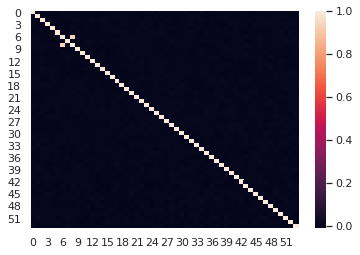

In [37]:
sns.heatmap(data_train.corr())

So, our data 0-correlated (this is a little bit suspiciously...), just 2 features have 1 correlation value.

In [38]:
dtemp = data_train.iloc[:,3:10]
dtemp.head(8)

,3,4,5,6,7,8,9
0,221,382,97,-4.472136,0.107472,0,132
1,232,1,198,7.810250,0.763713,1,143
2,111,111,146,8.602325,0.651162,1,430
3,370,208,158,8.306624,0.424645,1,340
4,218,317,301,8.124038,0.767304,1,212
5,350,428,359,5.830952,0.505189,1,73
6,67,388,326,-1.414214,0.604309,0,258
7,317,359,116,-6.324555,0.022464,0,485


About 2 correlated features - "8" is boolean, it represents sign of feature "6", soon I'll drop "8"

In [39]:
data_train.iloc[:,4:10].describe()

,4,5,6,7,8,9
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,249.436178,249.656167,-0.011402,0.498548,0.499189,249.842033
std,143.941581,144.329168,7.038171,0.288682,0.500002,144.612718
min,0.000000,0.000000,-9.949874,0.000014,0.000000,0.000000
25%,125.000000,124.000000,-7.071068,0.248932,0.000000,124.000000
50%,250.000000,250.000000,0.000000,0.497136,0.000000,250.000000
75%,373.000000,374.000000,7.000000,0.747513,1.000000,376.000000
max,499.000000,499.000000,9.949874,0.999987,1.000000,499.000000


First columns - "0", "1"... with int values - are descrite values from 0 to 499. Mean is about 250, and quantiles are strange, so date may be uniformly destributed. For other values, floats from 0 to 15 - destribution seems uniform, too, as you can see below

In [40]:
data_train.iloc[:,48:54].describe()

,48,49,50,51,52,target
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,7.490658,7.474578,7.509206,7.487159,7.513316,50.033981
std,4.332122,4.323035,4.326364,4.324876,4.333080,28.897243
min,0.000367,0.000014,0.000160,0.000147,0.000125,0.002634
25%,3.739358,3.715298,3.773381,3.743536,3.776322,25.091903
50%,7.494167,7.477270,7.512575,7.476564,7.506812,50.030705
75%,11.239232,11.210070,11.268156,11.234414,11.277835,75.059454
max,14.999869,14.999928,14.999948,14.999364,14.999775,99.999482


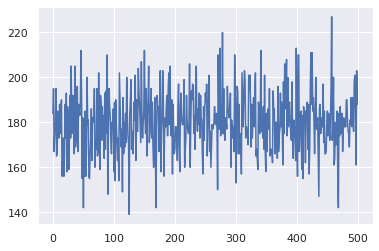

In [41]:
plt.plot(data_train['1'].value_counts().sort_index())
#In the int-columns we meet each value from 140 to 220 times, and 180 in avarage, it's seems regularity with some noise

(array([9088., 9056., 8948., 8912., 9036., 9025., 8902., 9106., 8965.,
        8962.]),
 array([3.67375445e-04, 1.50031758e+00, 3.00026778e+00, 4.50021798e+00,
        6.00016818e+00, 7.50011838e+00, 9.00006858e+00, 1.05000188e+01,
        1.19999690e+01, 1.34999192e+01, 1.49998694e+01]),
 <a list of 10 Patch objects>)

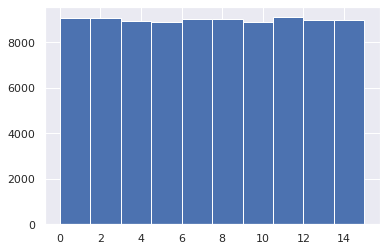

In [42]:
plt.hist(data_train['48'])
#Float-columns are follow сontinuous uniform distribution

(array([9084., 8948., 8967., 8944., 9033., 8855., 9011., 9197., 8967.,
        8994.]),
 array([2.63446314e-03, 1.00023192e+01, 2.00020040e+01, 3.00016888e+01,
        4.00013736e+01, 5.00010584e+01, 6.00007432e+01, 7.00004279e+01,
        8.00001127e+01, 8.99997975e+01, 9.99994823e+01]),
 <a list of 10 Patch objects>)

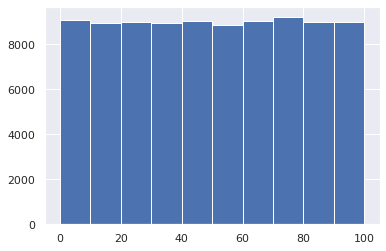

In [43]:
plt.hist(data_train['target'])
#target value seems sсaled like 2nd  type of columns, but in range from 0 to 100

The conclusion suggests itself that the data is synthetic, and their distributions are artificially biased.

Perhaps the data has been scaled based on its value in each column - if the value is the minimum it will be around 0, if its position is 45000 it will be 7.5, etc.

Therefore, the plan for solving the problem is to partially restore the scaling, for example, add polynomial features.
After that, you can run linear regression and get a model that predicts the target value

In [44]:
y = data_train["target"]
droped = ["target", "8"]
X = data_train.drop(droped, axis = 1)
X.shape

(90000, 52)

In [45]:
polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
X_a = polynomial_features.fit_transform(X) # adding polinomial features
X_a.shape # now we have 1400+ features instead of 50

(90000, 1431)

Let's split our dataset on train and validation sets. Our model will be trained on X_train, and evaluated on X_val. And after that we will make a prediction on test dataset, with hidden target

By the way, we don't need scaling in this task, because the data is scaled for us at the initial stage.

In [46]:
X_train,X_val, y_train, y_val = train_test_split(X_a,y, test_size = 0.1)
X_train.shape 

(81000, 1431)

In [47]:
reg = linear_model.LinearRegression() 
reg.fit(X_train, y_train) # here we need 1 Gb for allocation data in memory 
# There is such an amount of memory in my computer, but to access to it was necessary to use Google Collab
# This computation takes about 30 sec on Intel Core i5

w = reg.coef_  # weights of features
x0 = reg.intercept_ # bias parameter
print(w[0:10])
print(x0)

[-4.60648325e-04 -3.50370964e-13 -1.25726469e-13 -3.22202958e-13
 -1.41497708e-13 -1.28253528e-13 -2.56624637e-13  5.49582190e-13
  1.00000000e+00  1.33503451e-13]
0.000460648284843046


For prediction we need preprocess our data(drop some columns, add polinomial features) then multiply it with vectors of weigths, and add x0 to result. 

Let's see RMSE of our model on train and validation set

In [48]:
error_train = mean_squared_error(y_true = y_train, y_pred = X_train.dot(w)+reg.intercept_)
error_val = mean_squared_error(y_true = y_val, y_pred = X_val.dot(w)+reg.intercept_)
print("Train set error: ", error_train)
print("Validation set error: ", error_val)

Train set error:  3.6734841538405823e-20
Validation set error:  3.7252299287316084e-20


Wow! Train error is incredibly small! It may be a overfitting, but validation error is as small, as train error!

So, probably, our model just got the point!

Now we can make prediction on our test set with hidden target

In [49]:
def preprocessing(X):
  X = X.drop("8", axis = 1)
  polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
  X = polynomial_features.fit_transform(X)
  return X

def predict(X, w, x0):
  return X.dot(w)+x0

def loss(y_true, y_pred):
  return mean_squared_error(y_true = y_true, y_pred = y_pred)

In [51]:
X_test = preprocessing(data_test)
y_test = predict(X_test, w, x0)
print(y_test[0:10])

[11.21876001 79.70022802  7.49455605 38.5111167  64.75641595 38.49535942
 94.87079841 97.44690755 29.62908153 26.2770368 ]


### So, we got compured weigths and prediction for our test set.

Results are really good, model predict data with high accuracy, so overfitting on synthetic data does not appear, so I don't use cross validation and other methods to avoid it